In [4]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np
import cftime

from dask_kubernetes import KubeCluster
from dask.distributed import Client, TimeoutError
from dask.distributed import wait, progress
#import six

ModuleNotFoundError: No module named 'nc_time_axis'

In [8]:
#As it can take some time to spin up first start the Dask cluster
# Select 20 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
try:
    client = Client('tcp://localhost:33949', timeout='2s')
    new_cluster = False
except TimeoutError:
    print('NOOO!')
    cluster = KubeCluster(n_workers=20)
    cluster
    new_cluster = True

In [33]:
def simple_sum(filename):
    try: #catch two common errors
        this_dataset = pyart.aux_io.read_odim_h5(filename)
        fp = 1
        time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
        tgates = float(this_dataset.ngates*this_dataset.nrays)
        zdat = this_dataset.fields['reflectivity']['data']
        fp = 2
        z0 = float(len(np.where(zdat > 0.)[0]))/tgates
        z10 = float(len(np.where(zdat > 10.)[0]))/tgates
        z40 = float(len(np.where(zdat > 40.)[0]))/tgates
                
        grids = pyart.map.grid_from_radars(this_dataset,(31,801,801),
                   ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                   fields=this_dataset.fields.keys(),
                   refl_field='reflectivity', weighting_function='BARNES2')  
        
        z_prof_mean = grids.fields['reflectivity']['data'].mean(axis=(1,2))
        z_prof_max = grids.fields['reflectivity']['data'].max(axis=(1,2))
        npts_over = np.array([float(len(np.where(grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])
        
        del this_dataset, grids
        rv = (time_start, z0, z10, z40, 
              z_prof_mean, z_prof_max, npts_over)
    except (TypeError, KeyError) as e:
        rv = 'error'
    return rv


In [10]:
indir = os.path.expanduser('~/data/aus/terryhills/')

In [11]:
files = os.listdir(indir)

In [12]:
files = [os.path.join(indir, thise) for thise in files]

In [32]:
simple_sum(files[0])

AttributeError: 'real_datetime' object has no attribute 'datetime'

In [14]:
# Attach Dask to the cluster
if new_cluster:
    client = Client(cluster)

In [15]:
client

Client Scheduler: tcp://localhost:33949 Dashboard: /user/openradar-ausopenradar2019-2kcgg639/proxy/8787/status,Cluster Workers: 100 Cores: 200 Memory: 700.00 GB


In [16]:
future = client.map(simple_sum, files)


In [17]:
progress(future)

VBox()

In [18]:
my_data = client.gather(future)

In [ ]:
#my_data = client.gather(future)

In [19]:
#filtered_data = filter(lambda i:not(type(i) is str), my_data)
filtered_data = [value for value in my_data if type(value) != str]

In [20]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])
zprof = np.array([tpl[4] for tpl in filtered_data])
zprofmax = np.array([tpl[5] for tpl in filtered_data])
npts = np.array([tpl[6] for tpl in filtered_data])



In [21]:
order = np.argsort(times)

In [34]:
nptimes = times.astype('datetime64[ns]')

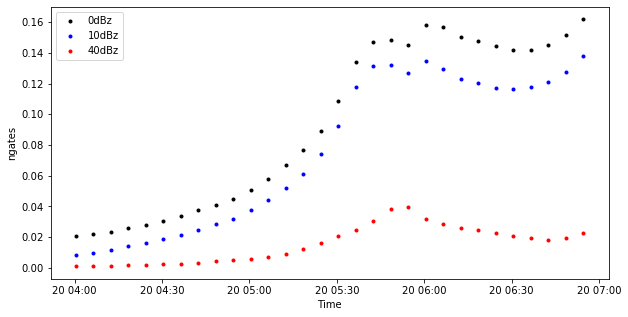

In [36]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(nptimes[order], z0[order], '.k', label='0dBz')
plt.plot(nptimes[order], z10[order], '.b', label='10dBz')
plt.plot(nptimes[order], z40[order], '.r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()

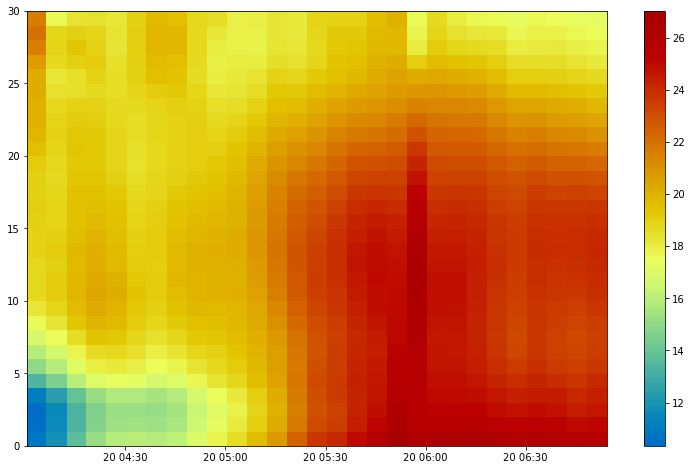

In [37]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(nptimes[order], range(31), zprof[order].transpose(),
              cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times[order], range(31), zprofmax[order].transpose(), vmin=0, vmax=65,
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times[order], range(31), npts[order].transpose()/(801**2),
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar()

In [ ]:
z_prof_max = grids.fields['reflectivity']['data'].max(axis=(1,2))

In [ ]:
npts_over = np.array([float(len(np.where(grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])

In [ ]:
npts_over